# COIN-OR: MILP (Gemischt-ganzzahlige Optimierung)

In [1]:
import json
import pulp
import pandas as pd

In [2]:
import utils.presenter as show

In [3]:
from utils.checker import is_machine_conflict_free
from utils.checker import is_job_machine_sequence_correct

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

In [5]:
instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



# CBC (COIN-OR Branch and Cut)

In [8]:
def solve_jobshop_cbc(job_dict, solver_time_limit=300, epsilon=0):
    """
    Erste Stufe: Minimierung des Makespan (Gesamtdauer) eines Job-Shop-Problems.

    Parameter:
    - epsilon: Kleiner Sicherheitsabstand (in Minuten) zwischen Operationen auf derselben Maschine,
               um numerische Ungenauigkeiten und Maschinenkonflikte zu vermeiden (z.B. 0.06 Minuten = 3.6 Sekunden).
    """

    job_names = list(job_dict.keys())
    num_jobs = len(job_names)
    all_ops = list(job_dict.values())

    # Maschinen extrahieren
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem definieren
    prob = pulp.LpProblem("JobShop_Optimal_HiGHS", pulp.LpMinimize)

    # Variablen: Startzeiten
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    # Makespan-Variable
    makespan = pulp.LpVariable("makespan", lowBound=0, cat="Continuous")
    prob += makespan  # Ziel 1: Makespan minimieren

    # Technologische Reihenfolge (Ankunftszeit = 0)
    for j, job in enumerate(all_ops):
        prob += starts[(j, 0)] >= 0
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (mit kleinem Abstand epsilon)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Makespan-Bedingung für jede Job-Endoperation
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += makespan >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver starten
    solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnisse extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Duration": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    makespan_value = round(pulp.value(makespan), 3)

    return df_schedule, makespan_value

In [9]:
df_schedule_cbc, makespan = solve_jobshop_cbc(instance, solver_time_limit=240)
df_schedule_cbc

,Job,Machine,Start,Duration,End
0,job 0,M0,274.0,29,303.0
1,job 0,M1,461.0,78,539.0
2,job 0,M2,689.0,9,698.0
3,job 0,M3,698.0,36,734.0
4,job 0,M4,734.0,49,783.0
...,...,...,...,...,...
95,job 9,M9,533.0,76,609.0
96,job 9,M5,609.0,47,656.0
97,job 9,M3,734.0,52,786.0
98,job 9,M4,786.0,90,876.0


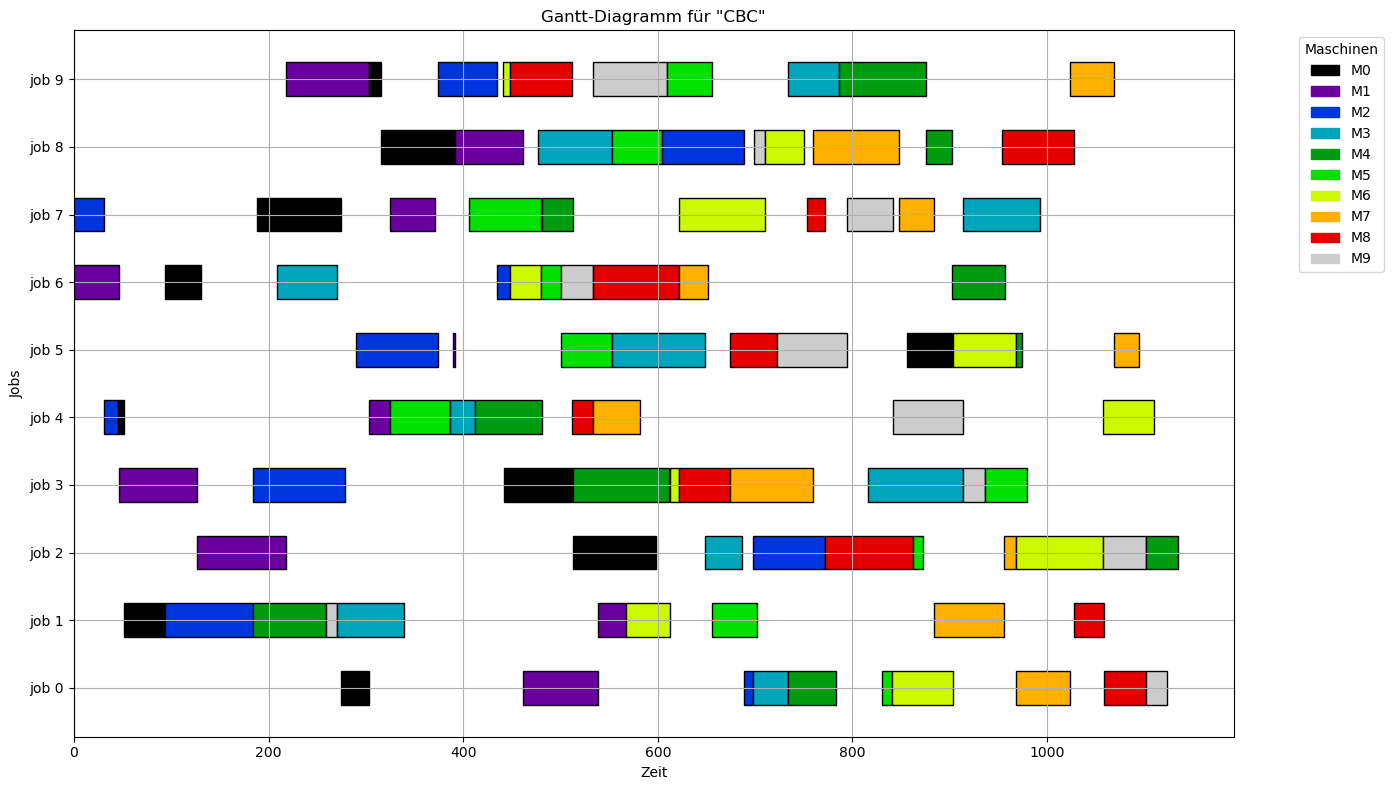

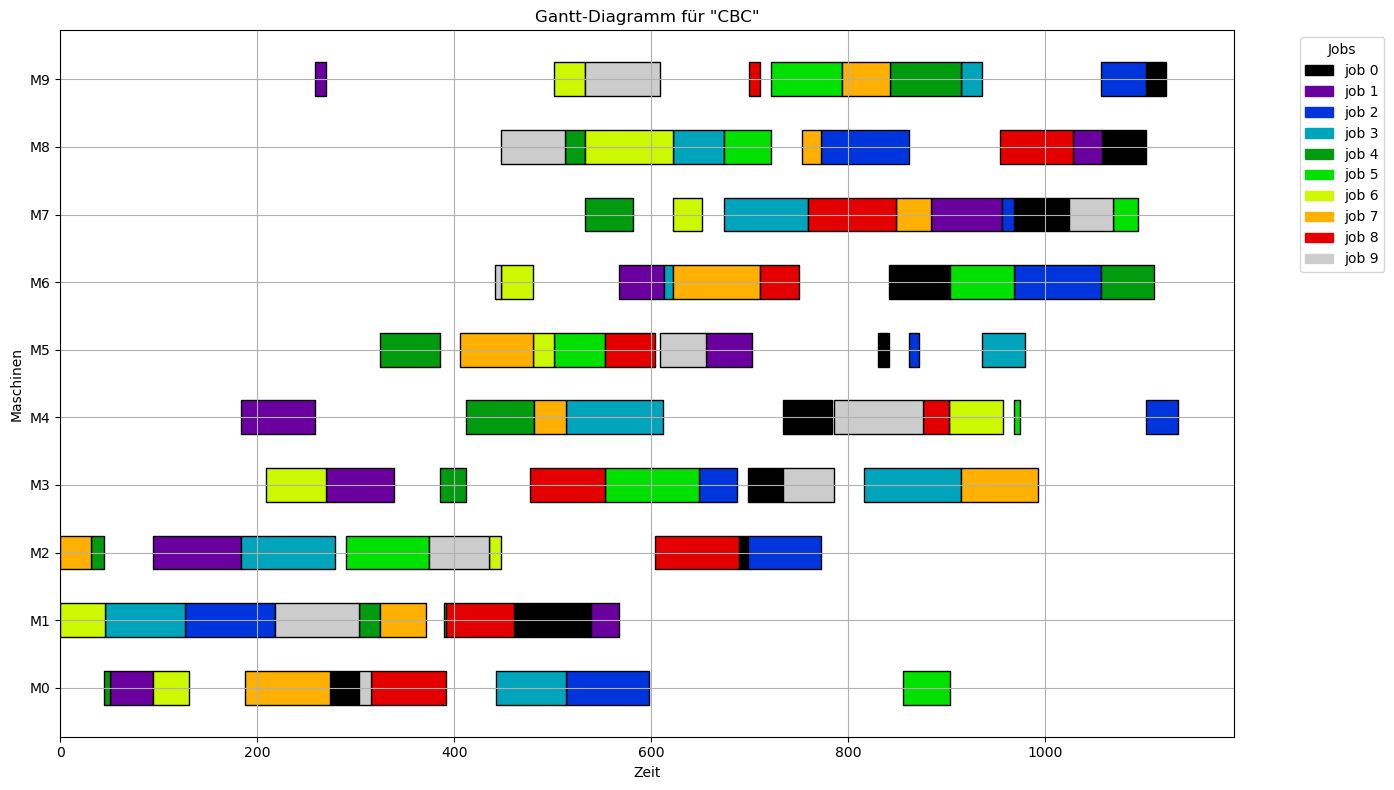

In [10]:
category = "CBC"
show.plot_gantt_jobs(df_schedule_cbc, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule_cbc, 'Gantt-Diagramm für "{}"'.format(category))

In [11]:
is_machine_conflict_free(df_schedule_cbc)
is_job_machine_sequence_correct(df_schedule_cbc, instance)

True

# HiGHS mit PuLP
high performance serial and parallel solver

In [13]:
# conda install -c conda-forge highs

In [14]:
def solve_jobshop_highs(job_dict, solver_time_limit=300, epsilon=0):
    """
    Erste Stufe: Minimierung des Makespan (Gesamtdauer) eines Job-Shop-Problems.

    Parameter:
    - epsilon: Kleiner Sicherheitsabstand (in Minuten) zwischen Operationen auf derselben Maschine,
               um numerische Ungenauigkeiten und Maschinenkonflikte zu vermeiden (z.B. 0.06 Minuten = 3.6 Sekunden).
    """

    job_names = list(job_dict.keys())
    num_jobs = len(job_names)
    all_ops = list(job_dict.values())

    # Maschinen extrahieren
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem definieren
    prob = pulp.LpProblem("JobShop_Optimal_HiGHS", pulp.LpMinimize)

    # Variablen: Startzeiten
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    # Makespan-Variable
    makespan = pulp.LpVariable("makespan", lowBound=0, cat="Continuous")
    prob += makespan  # Ziel 1: Makespan minimieren

    # Technologische Reihenfolge (Ankunftszeit = 0)
    for j, job in enumerate(all_ops):
        prob += starts[(j, 0)] >= 0
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (mit kleinem Abstand epsilon)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Makespan-Bedingung für jede Job-Endoperation
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += makespan >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver starten
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnisse extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Duration": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    makespan_value = round(pulp.value(makespan), 3)

    return df_schedule, makespan_value

In [34]:
df_schedule_highs, makespan = solve_jobshop_highs(instance, solver_time_limit=3600)
df_schedule_highs
print(f"Makespan: {makespan} Minuten")

Makespan: 944.0 Minuten


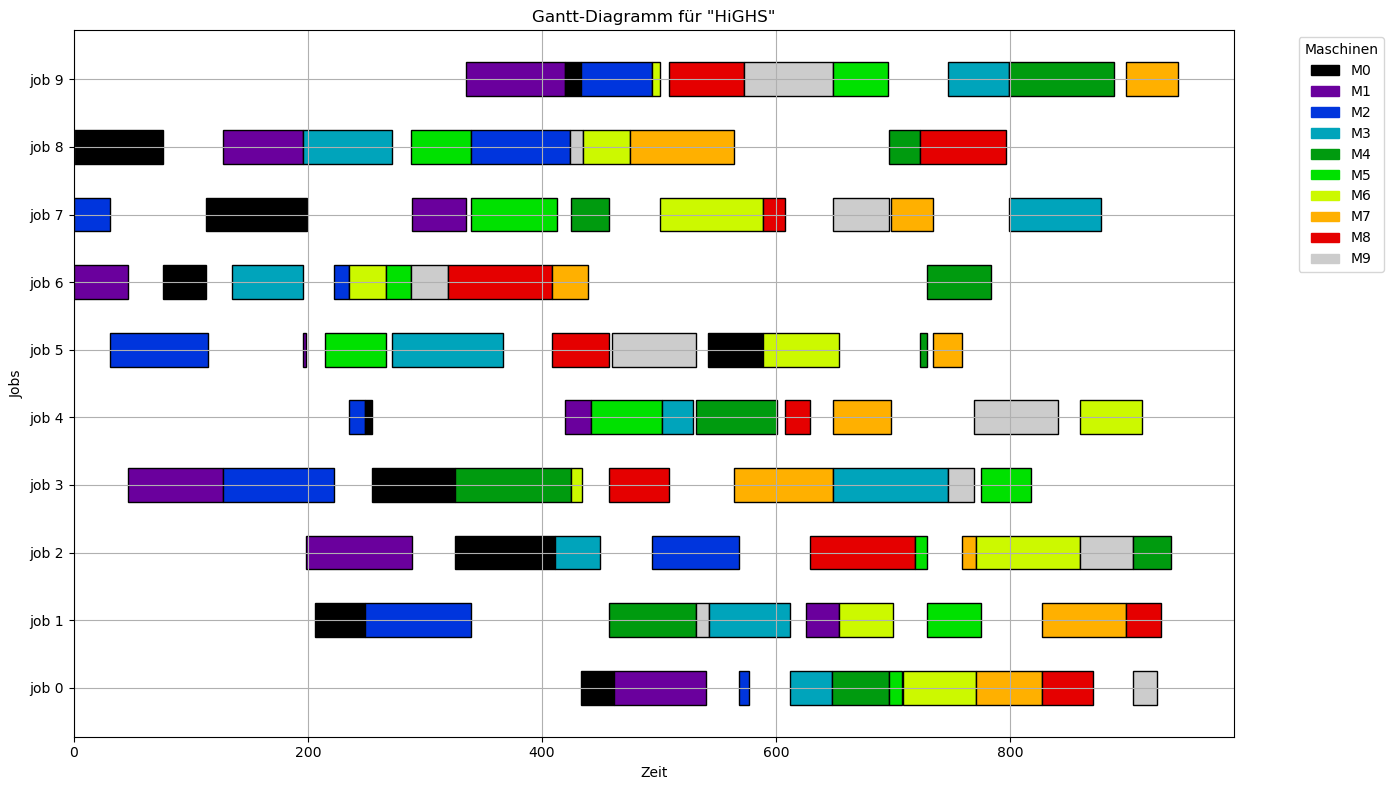

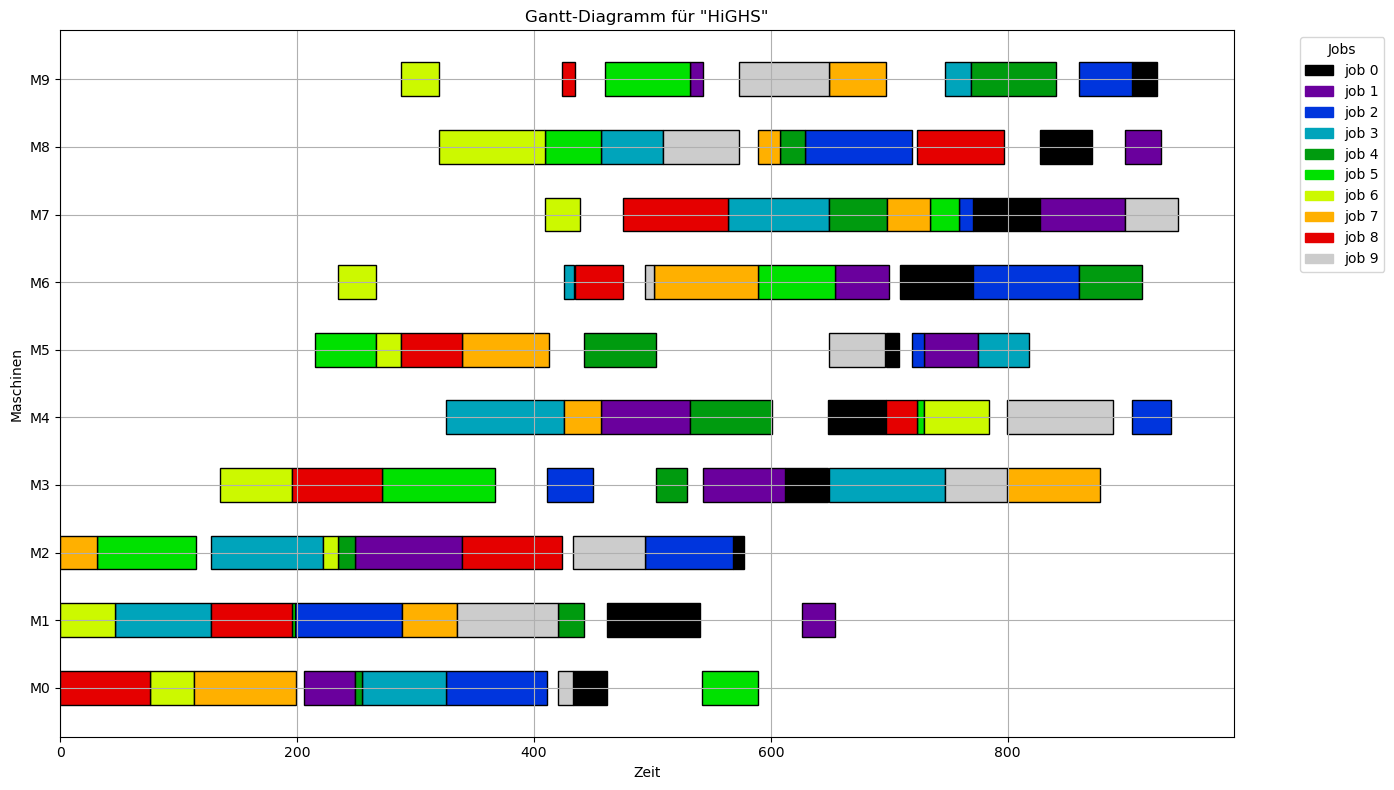

In [35]:
category = "HiGHS"
show.plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

In [36]:
is_machine_conflict_free(df_schedule_highs)
is_job_machine_sequence_correct(df_schedule_highs, instance)

True

In [18]:
df_schedule_highs.to_csv('data/01_schedule_highs.csv', index=False)

## Solver-Algorithmus Test

In [6]:
import utils.schedule_solver as ssv

In [7]:
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [8]:
df_arrivals = pd.DataFrame({
    "Job-ID": list(instance.keys()),
    "Ankunftszeit (Minuten)": [0] * len(instance)
})

df_arrivals

,Job-ID,Ankunftszeit (Minuten)
0,job 0,0
1,job 1,0
2,job 2,0
3,job 3,0
4,job 4,0
5,job 5,0
6,job 6,0
7,job 7,0
8,job 8,0
9,job 9,0


In [9]:
time_sec = 12*60*60
df_schedule_plan, makespan = ssv.solve_jssp_total_individual_makespans(instance, df_arrivals, solver_time_limit=time_sec)
df_schedule_plan

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 43200
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/f294609e07f0491793921d8164da4625-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/f294609e07f0491793921d8164da4625-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 450
MIP  f294609e07f0491793921d8164da4625-pulp has 1010 rows; 560 cols; 2910 nonzeros; 450 integer variables (450 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
990 rows, 550 cols, 2880 nonzeros  0s
540 rows, 550 cols, 1530 nonzeros  0s
540 rows, 550 cols, 1530 nonzeros  0s

Solving MIP model with:
   540 rows
   550 cols (450 binary, 0 integer, 0 implied int., 100 continuous)
   1530 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pu

,Job,Machine,Start,Duration,End,Ankunft,Durchlaufzeit
0,job 0,M0,0.00,29,29.00,0,29.00
1,job 0,M1,68.01,78,146.01,0,146.01
2,job 0,M2,157.01,9,166.01,0,166.01
3,job 0,M3,170.01,36,206.01,0,206.01
4,job 0,M4,239.01,49,288.01,0,288.01
...,...,...,...,...,...,...,...
95,job 9,M9,525.01,76,601.01,0,601.01
96,job 9,M5,601.01,47,648.01,0,648.01
97,job 9,M3,648.01,52,700.01,0,700.01
98,job 9,M4,700.01,90,790.01,0,790.01


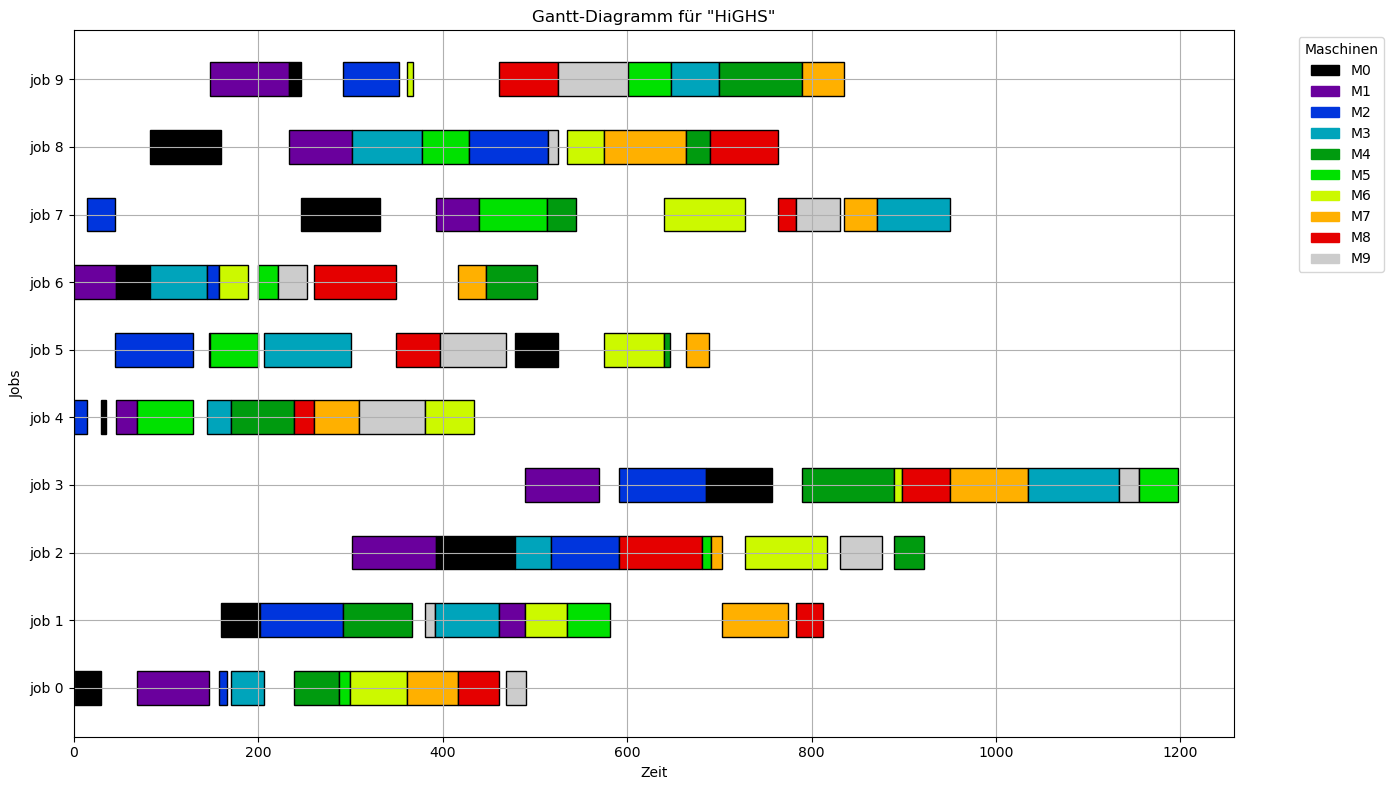

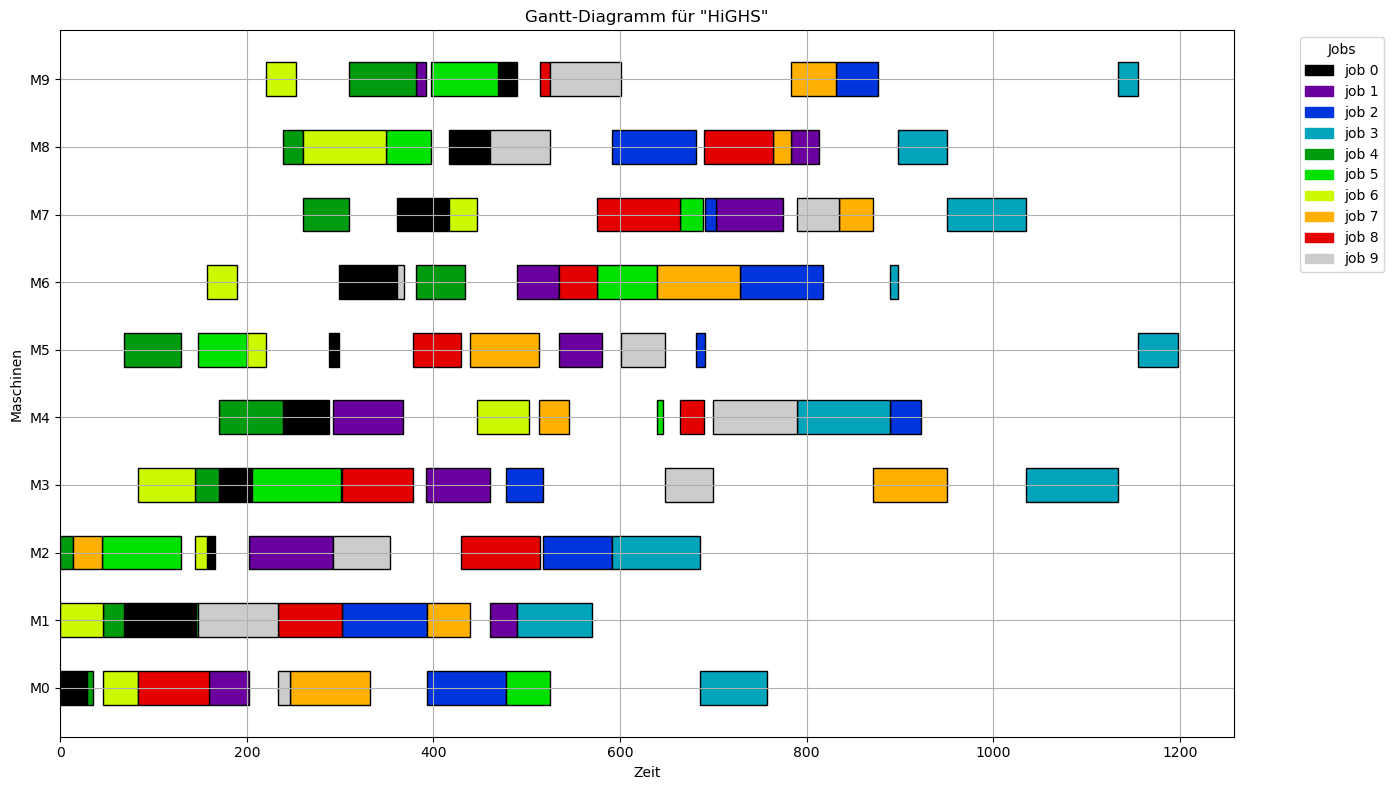

True

In [12]:
category = "HiGHS"
show.plot_gantt_jobs(df_schedule_plan, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule_plan, 'Gantt-Diagramm für "{}"'.format(category))

is_machine_conflict_free(df_schedule_plan)
is_job_machine_sequence_correct(df_schedule_plan, instance)

In [13]:
df_schedule_plan.to_csv('data/01b_schedule_plan_12h.csv', index=False)